In [1]:
import os

from src.load_data import load_matches
from src.offball_wrappers import a_obr_per_subtype,a_obr_per_subtype_per_phase, a_obr_per_subtype_per_team, a_obr_per_subtype_per_player 
from src.density_change import a_ddc_distance_player
from src.space_creation import metric_sc

## IMPORTANT
The probability that a goal will be scored 10 seconds after a player is successfully served a pass.
If the player was not targeted by a pass, it is calculated at the passing moment. <-- This is the way they say how good a runner is or the effect that he has. However, this only refers if he receives the pass. But a lot of move form midfielders is not to receive the ball but to generate space or create passing options. Thats why we are doing this.!!!!

-----------------------------------------------------------------------------------------------------


2. Quadrant talent map
Make a 2D scatter:

x‑axis: space_creation per run (or per90).

y‑axis: defensive_density_change per run (or per90).

Color or size points by number of runs per90. Then define quadrants:

Top‑right: “elite space finders” – create space and get free a lot.

Top‑left: “pressure escapists” – get free but don’t open much space behind.

Bottom‑right: “space openers for others” – create space where they were but stay more marked.

Bottom‑left: low impact movers.

This is a very clear talent‑ID picture: look for young/underused players in the top‑right with decent volume.

-----------------------------------------------------------------------------------------------------

Also do violin plots for the thirds phases

-----------------------------------------------------------------------------------------------------

Do something with pushing defensive line in run in behind runs. Maybe scatter plot of pushing defensive line and if his run is a real passing option and the size of the circle is how many runs. or idk but it could be interesting if we can quantify if these run in behind runs are worth it (they push the defensive line and create space).

-----------------------------------------------------------------------------------------------------

In [2]:
# load matches
data_path = os.path.join(os.getcwd(), "src/data")
all_tracking, dynamic_events_all, all_metadata = load_matches(data_path)

c:\Users\g4a4b\OneDrive - University of Twente\SportsAnalyticsProject\analytics_cup_research\src\load_data.py:56: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)
c:\Users\g4a4b\OneDrive - University of Twente\SportsAnalyticsProject\analytics_cup_research\src\load_data.py:56: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)


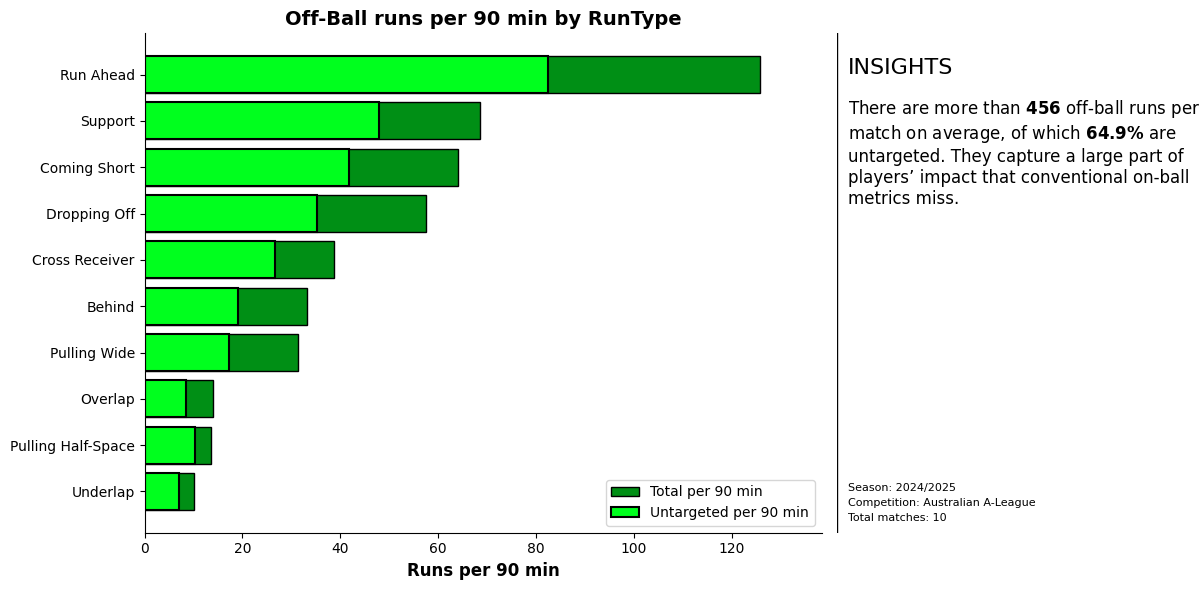

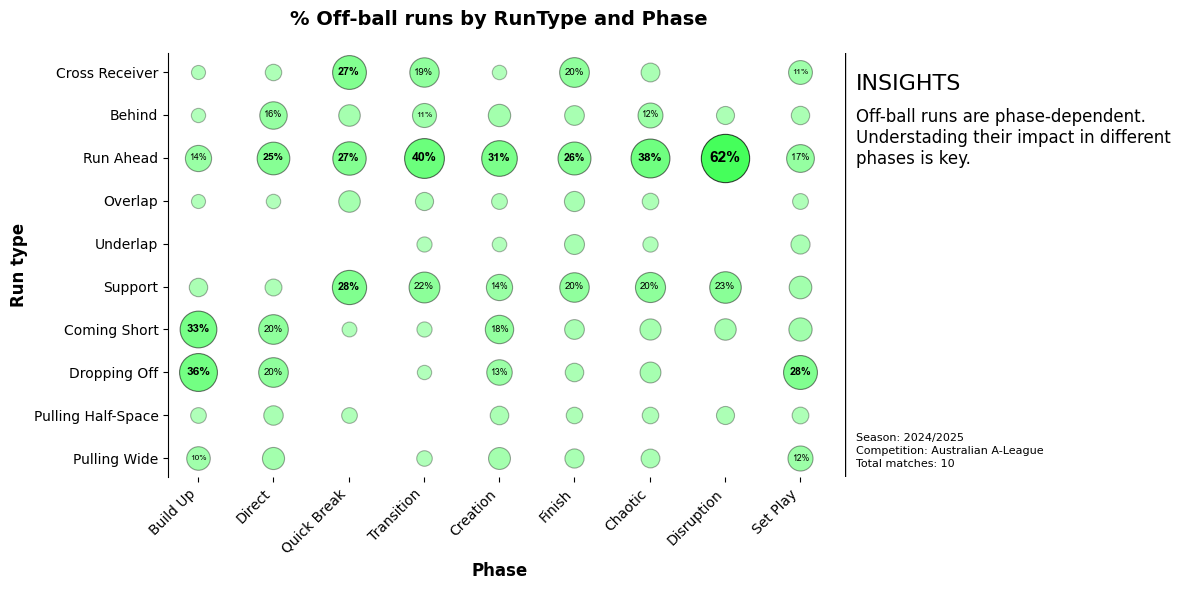

In [3]:
# analysis of off ball runs per 90 minutes
a_obr_per_subtype(all_tracking,dynamic_events_all)

# analysis of off ball runs per subtype per phase
a_obr_per_subtype_per_phase(dynamic_events_all)

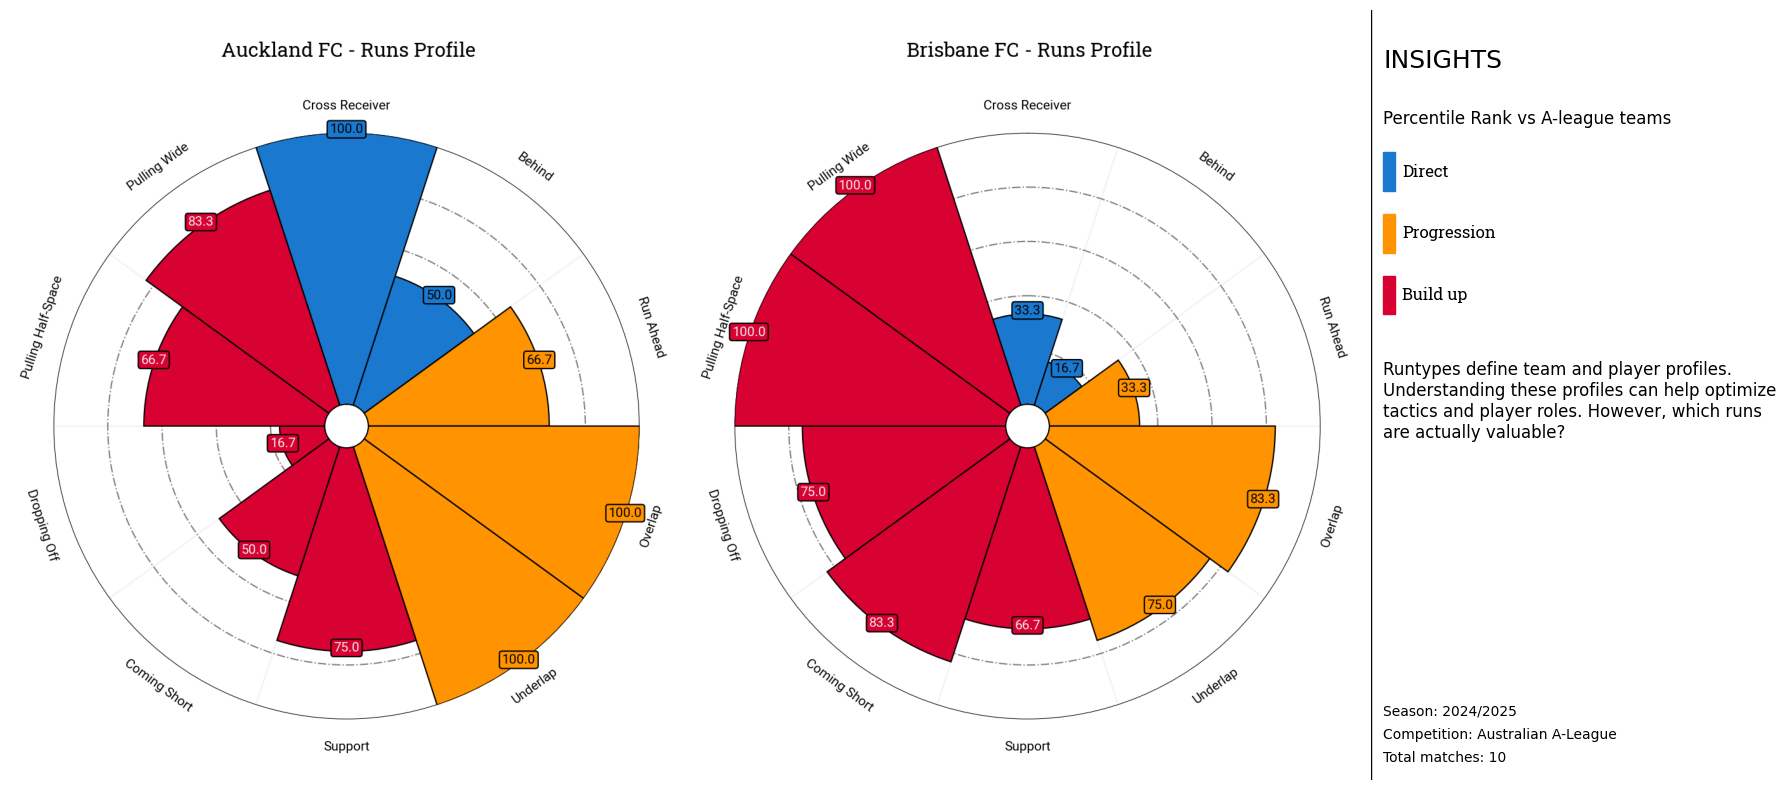

In [17]:
# analysis of off ball runs per subtype per team per 90 minutes
a_obr_per_subtype_per_team(all_tracking, dynamic_events_all, teams_shortnames=["Auckland FC", "Brisbane FC"])

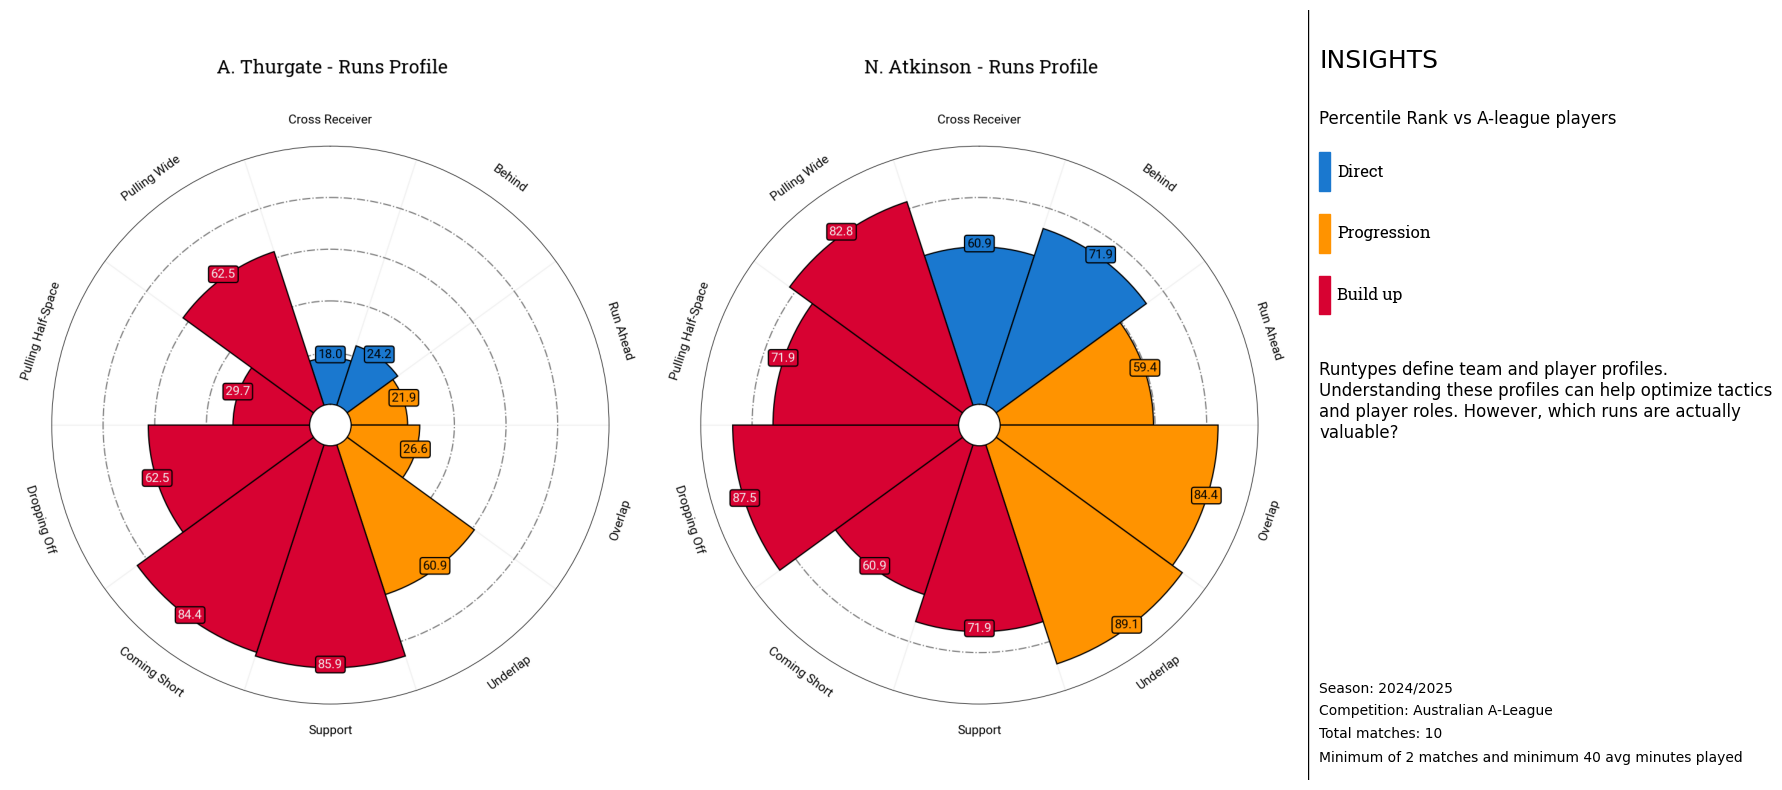

In [18]:
# analysis of off ball runs per subtype per player per 90 minutes
a_obr_per_subtype_per_player(all_metadata, dynamic_events_all, players_names = ["A. Thurgate", "N. Atkinson"], min_matches=2, min_avg_minutes_played=40)


Midfielders rank second in how evenly their off‑ball runs are spread across different run types, very close to forwards, while still accounting for a substantial share of all runs. Combined with the available physical aggregation data for this position group, this makes midfielders a natural choice for a deeper analysis of how off‑ball movement creates space and passing options.

Number of events to process for defensive density change: 691
Number of events after cleaning for defensive density change: 674


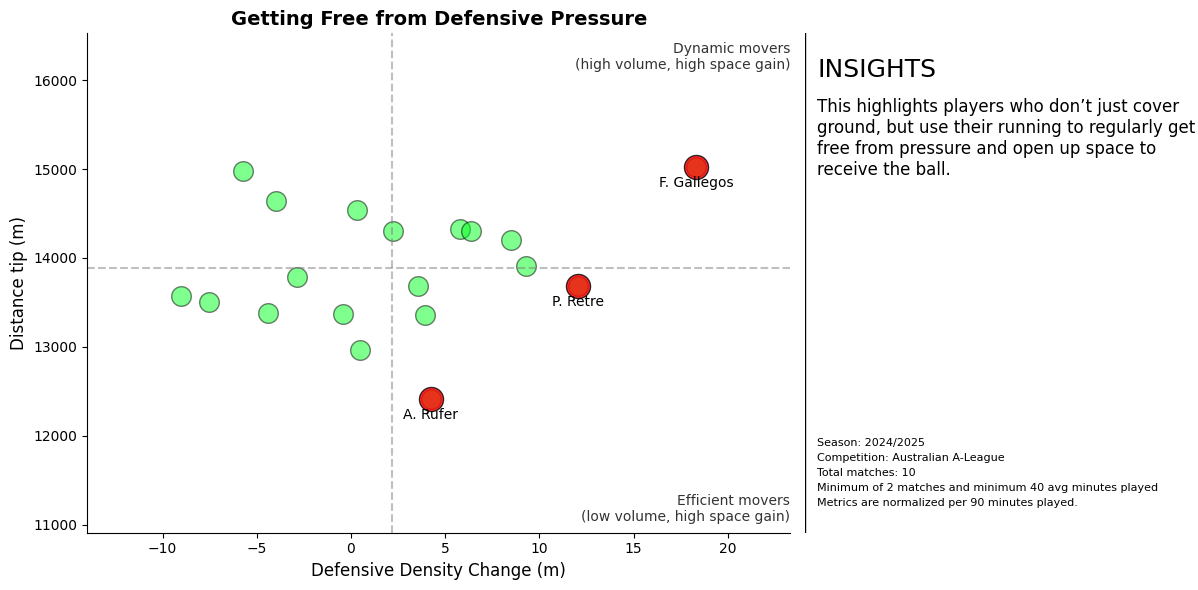

In [3]:
a_ddc_distance_player(dynamic_events_all, all_tracking, all_metadata, data_path, min_matches=2, min_avg_minutes_played=40)

In [4]:
mid_obr_grouped, mid_obr_merged = metric_sc(dynamic_events_all, all_tracking, all_metadata, min_matches=2, min_avg_minutes_played=40)

Number of events to process for space created: 641
Number of events after processing for space created: 625


In [ ]:
print(mid_obr_merged)
print("Number of players unique:", mid_obr_merged['player_id'].nunique())
print("Columns:", mid_obr_merged.columns)



     player_id    player_name      third_start        third_end  \
0        11117     Z. Machach  attacking_third  attacking_third   
1        11117     Z. Machach     middle_third  attacking_third   
2        23418    F. Gallegos  attacking_third     middle_third   
3        23418    F. Gallegos     middle_third     middle_third   
4        14736  L. Verstraete     middle_third     middle_third   
..         ...            ...              ...              ...   
620      14736  L. Verstraete     middle_third     middle_third   
621      14736  L. Verstraete     middle_third     middle_third   
622      23418    F. Gallegos     middle_third     middle_third   
623      23418    F. Gallegos     middle_third     middle_third   
624      23418    F. Gallegos     middle_third     middle_third   

             event_subtype  voronoi_area_start  voronoi_area_end  \
0                  support           48.159214        241.292706   
1    run_ahead_of_the_ball           45.426280        583.0

Do a code to visualize the outliers runs and check if they make sense

In [16]:
import numpy as np

# --------------------------------------------------
# 1. Configuration
# --------------------------------------------------
cols = ["voronoi_area_start", "voronoi_area_end", "space_created"]
col_idx = {
    "voronoi_area_start": 0,
    "voronoi_area_end": 1,
    "space_created": 2
}

# --------------------------------------------------
# 2. Convert DataFrame → NumPy
# --------------------------------------------------
X = mid_obr_merged[cols].to_numpy()
subtypes = mid_obr_merged["event_subtype"].to_numpy()

# --------------------------------------------------
# 3. Split by event subtype (NumPy)
# --------------------------------------------------
event_subtype_arrays = {
    s: X[subtypes == s]
    for s in np.unique(subtypes)
}

# --------------------------------------------------
# 4. Boxplot stats function (NumPy)
# --------------------------------------------------
def boxplot_stats_numpy(x):
    x = x[~np.isnan(x)]

    q1, q2, q3 = np.percentile(x, [25, 50, 75])
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    lower_whisker = x[x >= lower_bound].min()
    upper_whisker = x[x <= upper_bound].max()

    outliers = x[(x < lower_whisker) | (x > upper_whisker)]

    return {
        "Q1": q1,
        "median": q2,
        "Q3": q3,
        "IQR": iqr,
        "lower_whisker": lower_whisker,
        "upper_whisker": upper_whisker,
        "n": len(x),
        "n_outliers": len(outliers)
    }

# --------------------------------------------------
# 5. Whisker bounds helper (for row-wise outliers)
# --------------------------------------------------
def whisker_bounds_numpy(x):
    x = x[~np.isnan(x)]
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

# --------------------------------------------------
# 6. Compute stats per subtype & metric
# --------------------------------------------------
stats = {}

for subtype, arr in event_subtype_arrays.items():
    stats[subtype] = {}

    for col_name, idx in col_idx.items():
        stats[subtype][col_name] = boxplot_stats_numpy(arr[:, idx])

# --------------------------------------------------
# 7. Compute UNIQUE outlier rows per subtype
# --------------------------------------------------
outlier_rows_per_subtype = {}

for subtype, arr in event_subtype_arrays.items():
    row_outlier_mask = np.zeros(arr.shape[0], dtype=bool)

    for idx in col_idx.values():
        lower, upper = whisker_bounds_numpy(arr[:, idx])
        row_outlier_mask |= (arr[:, idx] < lower) | (arr[:, idx] > upper)

    # map back to original DataFrame indices (optional but useful)
    row_indices = np.where(subtypes == subtype)[0]
    outlier_indices = row_indices[row_outlier_mask]

    outlier_rows_per_subtype[subtype] = {
        "rows": arr[row_outlier_mask],
        "indices": outlier_indices
    }

# --------------------------------------------------
# 8. Print summary
# --------------------------------------------------
for subtype, metrics in stats.items():
    print(f"\n=== Event subtype: {subtype} ===")

    for metric, s in metrics.items():
        print(f"\n  {metric}")
        print(f"    n: {s['n']}")
        print(f"    Q1: {s['Q1']:.3f}")
        print(f"    Median: {s['median']:.3f}")
        print(f"    Q3: {s['Q3']:.3f}")
        print(f"    IQR: {s['IQR']:.3f}")
        print(f"    Lower whisker: {s['lower_whisker']:.3f}")
        print(f"    Upper whisker: {s['upper_whisker']:.3f}")
        print(f"    # Outliers (metric): {s['n_outliers']}")

    print(
        f"\n  >>> UNIQUE outlier rows (any metric): "
        f"{len(outlier_rows_per_subtype[subtype]['rows'])}"
    )



=== Event subtype: behind ===

  voronoi_area_start
    n: 17
    Q1: 72.538
    Median: 111.419
    Q3: 148.177
    IQR: 75.639
    Lower whisker: 24.407
    Upper whisker: 231.008
    # Outliers (metric): 3

  voronoi_area_end
    n: 17
    Q1: 101.952
    Median: 173.921
    Q3: 211.819
    IQR: 109.867
    Lower whisker: 78.426
    Upper whisker: 211.819
    # Outliers (metric): 4

  space_created
    n: 17
    Q1: -22.666
    Median: 21.237
    Q3: 103.217
    IQR: 125.883
    Lower whisker: -129.057
    Upper whisker: 171.780
    # Outliers (metric): 4

  >>> UNIQUE outlier rows (any metric): 5

=== Event subtype: coming_short ===

  voronoi_area_start
    n: 210
    Q1: 89.415
    Median: 125.292
    Q3: 177.850
    IQR: 88.435
    Lower whisker: 22.620
    Upper whisker: 284.925
    # Outliers (metric): 31

  voronoi_area_end
    n: 210
    Q1: 102.645
    Median: 142.824
    Q3: 443.186
    IQR: 340.541
    Lower whisker: 26.522
    Upper whisker: 917.425
    # Outliers (metr